## 1. 필요한 패키지 불러오기

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.sparse import csr_matrix
import re

from implicit.als import AlternatingLeastSquares
import os

## 2. [데이터 설명](https://grouplens.org/datasets/movielens/1m/)

**RATINGS FILE DESCRIPTION**


All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

**USERS FILE DESCRIPTION**


User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

**MOVIES FILE DESCRIPTION**


Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

## 3. 필요한 데이터 불러오기

In [2]:
ratings_col = ["UserID", "MovieID", "Rating", "Timestamp"]
users_col = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
movies_col = ["MovieID", "Title", "Genres"]

ratings = pd.read_csv("./data/ml-1m/ratings.dat", names = ratings_col, sep="::", engine = "python", encoding = "ISO-8859-1")
movies = pd.read_csv("./data/ml-1m/movies.dat", names = movies_col, sep="::", engine = "python", encoding = "ISO-8859-1")
users = pd.read_csv("./data/ml-1m/users.dat", names = users_col, sep="::", engine = "python", encoding = "ISO-8859-1")

#### users data

In [3]:
print(f"데이터 개수 : {users.shape[0]}")
print(f"변수 개수 : {users.shape[1]}")
print(f"변수명 : {list(users.columns)}")
users.head()

데이터 개수 : 6040
변수 개수 : 5
변수명 : ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
users.isnull().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

#### movies data

In [5]:
print(f"데이터 개수 : {movies.shape[0]}")
print(f"변수 개수 : {movies.shape[1]}")
print(f"변수명 : {list(movies.columns)}")
movies.head()

데이터 개수 : 3883
변수 개수 : 3
변수명 : ['MovieID', 'Title', 'Genres']


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.isnull().sum()

MovieID    0
Title      0
Genres     0
dtype: int64

#### ratings data

In [7]:
print(f"데이터 개수 : {ratings.shape[0]}")
print(f"변수 개수 : {ratings.shape[1]}")
print(f"변수명 : {list(ratings.columns)}")
ratings.head()

데이터 개수 : 1000209
변수 개수 : 4
변수명 : ['UserID', 'MovieID', 'Rating', 'Timestamp']


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
ratings.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

#### data merging

In [9]:
a = np.unique(ratings["MovieID"])
b = np.unique(movies["MovieID"])
len(a), len(b)

(3706, 3883)

ratings 데이터셋에 있는 MovieID는 3706개이고 movies 데이터셋에 있는 MovieID는 3883개인데 추천 모델에 사용할 데이터는 ratings이 있는 데이터를 사용하기 때문에 점수가 없는 영화들은 사용하지 않겠습니다.

In [10]:
ratings_movies = pd.merge(left = ratings , right = movies, how = "inner", on = "MovieID")

그러므로 ratings와 movies를 inner join을 해주겠습니다.

In [11]:
total_data = pd.merge(left = users , right = ratings_movies, how = "inner", on = "UserID")
print(f"데이터 개수 : {total_data.shape[0]}")
print(f"변수 개수 : {total_data.shape[1]}")
print(f"변수명 : {list(total_data.columns)}")
del total_data["Zip-code"]
total_data.head()

데이터 개수 : 1000209
변수 개수 : 10
변수명 : ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code', 'MovieID', 'Rating', 'Timestamp', 'Title', 'Genres']


,UserID,Gender,Age,Occupation,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,F,1,10,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,F,1,10,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,F,1,10,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,F,1,10,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


users 데이터셋까지 inner join을 해주어서 모든 변수가 포함된 total 데이터셋을 만들었습니다.

## 4. 데이터 전처리 및 시각화

- 3점 이상인 데이터만 사용
- Title 숫자 제거
- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [12]:
total_data = total_data[total_data["Rating"] >= 3]
total_data = total_data.reset_index(drop=True)
total_data

,UserID,Gender,Age,Occupation,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,F,1,10,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,F,1,10,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,F,1,10,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,F,1,10,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...
836473,6040,M,25,6,263,4,960971893,Ladybird Ladybird (1994),Drama
836474,6040,M,25,6,1150,5,956715569,"Return of Martin Guerre, The (Retour de Martin...",Drama
836475,6040,M,25,6,3289,5,956704305,Not One Less (Yi ge dou bu neng shao) (1999),Drama
836476,6040,M,25,6,722,3,960971992,"Haunted World of Edward D. Wood Jr., The (1995)",Documentary


Rating이 3점 이상인 데이터만 사용하겠습니다.

#### Title 연도 제거

In [63]:
def title_preprocessing(title):
    title = re.sub("[^a-zA-Z]", " ", title)
    title = re.sub("[ ]+", " ", title).strip()
    return title

In [64]:
total_data["Title"] = total_data["Title"].apply(title_preprocessing)
total_data

,UserID,Gender,Age,Occupation,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,1193,5,978300760,One Flew Over the Cuckoo s Nest,Drama
1,1,F,1,10,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical
2,1,F,1,10,914,3,978301968,My Fair Lady,Musical|Romance
3,1,F,1,10,3408,4,978300275,Erin Brockovich,Drama
4,1,F,1,10,2355,5,978824291,Bug s Life A,Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...
836473,6040,M,25,6,263,4,960971893,Ladybird Ladybird,Drama
836474,6040,M,25,6,1150,5,956715569,Return of Martin Guerre The Retour de Martin G...,Drama
836475,6040,M,25,6,3289,5,956704305,Not One Less Yi ge dou bu neng shao,Drama
836476,6040,M,25,6,722,3,960971992,Haunted World of Edward D Wood Jr The,Documentary


#### Genres별 영화의 개수

In [177]:
cp_total_data = total_data.copy()
genre_bin = cp_total_data[["MovieID", "Genres"]].drop_duplicates().groupby("Genres").count().sort_values("MovieID", ascending=False)
genre_bin = genre_bin.rename(columns = {"MovieID":"bin"})
genre_bin

,bin
Genres,
Drama,731
Comedy,487
Horror,170
Comedy|Drama,149
Comedy|Romance,138
...,...
Animation|Children's|Fantasy|War,1
Animation|Children's|Musical|Romance,1
Animation|Mystery,1


In [178]:
genre_bin.describe()

,bin
count,301.000000
mean,12.053156
std,53.808709
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,731.000000


드라마와 코미디장르의 영화의 개수가 다른 장르에 비해서 너무 많기 때문에 마지막 모델이 추천하는 단계에서 사용자의 성향과 관계없이 드라마나 코미디 장르만 추천하는 모델이 나올지도 모르겠습니다.

#### ratings에 따른 영화의 개수

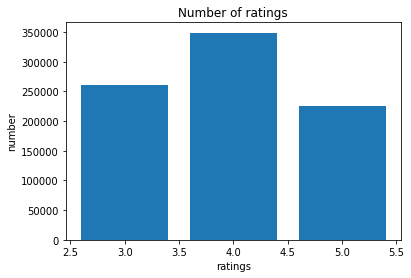

In [66]:
rating_count = total_data.groupby("Rating").count().iloc[:,0]
plt.bar(rating_count.index, height = rating_count.values)
plt.title("Number of ratings")
plt.xlabel("ratings")
plt.ylabel("number")
plt.show()

#### 사용자별 영화 ratings heatmap

In [67]:
user_title = pd.pivot_table(total_data, index = "UserID", columns = "MovieID", values = "Rating")
user_title = user_title.fillna(0)
user_title.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


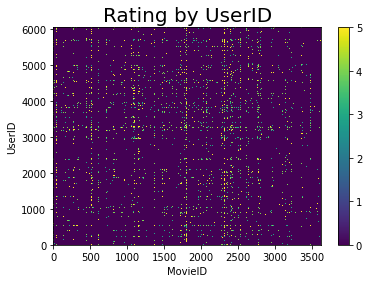

In [17]:
plt.pcolor(user_title)
plt.title('Rating by UserID', fontsize=20)
plt.xlabel("MovieID")
plt.ylabel("UserID")
plt.colorbar()

#### 가장 인기있는 영화 30개 뽑기

Rating에서 5점을 받은 횟수를 기준으로 횟구가 큰 영화를 30개 뽑겠습니다.

In [68]:
rating5_movie = total_data.groupby(["MovieID", "Rating"]).count().iloc[:,0].unstack()[5]
top30_movie = rating5_movie.sort_values(ascending=False)[:30]

ID_Title = {total_data["MovieID"][i] : total_data["Title"][i] for i in tqdm(range(len(total_data)))}
Title_ID = {total_data["Title"][i] : total_data["MovieID"][i] for i in tqdm(range(len(total_data)))}

top30_movie_title = [ID_Title[i] for i in top30_movie.index]

100%|██████████| 836478/836478 [00:10<00:00, 81997.04it/s]


In [69]:
top_30_movie = pd.DataFrame(top30_movie.values, index = top30_movie_title, columns= ["bin"])
top_30_movie

,bin
American Beauty,1963.0
Star Wars Episode IV A New Hope,1826.0
Raiders of the Lost Ark,1500.0
Star Wars Episode V The Empire Strikes Back,1483.0
Godfather The,1475.0
Schindler s List,1475.0
Shawshank Redemption The,1457.0
Matrix The,1430.0
Saving Private Ryan,1405.0
Sixth Sense The,1385.0


## 5. 내가 선호하는 영화를 5가지 골라서 추가하기

In [137]:
cp_total_data = total_data.copy()
my_favorite_movie = [[6041, "M", 25, 0, 3953, 4, 978301968, "Iron man", "Sci-Fi"],
                     [6041, "M", 25, 0, 3954, 3, 978301969, "Kimino name", "Animation"],
                     [6041, "M", 25, 0, 3955, 5, 975304914, "Avengers", "Action|Scif-FI"],
                     [6041, "M", 25, 0, 3956, 3, 961630133, "D.P", "Drama"],
                     [6041, "M", 25, 0, 3957, 5, 965531134, "Spier man", "Sci-Fi"]
                    ]
my_favorite_movie = pd.DataFrame(my_favorite_movie, columns = cp_total_data.columns)
cp_total_data = pd.concat([cp_total_data, my_favorite_movie], axis=0).reset_index(drop=True)

In [138]:
cp_total_data.tail()

,UserID,Gender,Age,Occupation,MovieID,Rating,Timestamp,Title,Genres
836478,6041,M,25,0,3953,4,978301968,Iron man,Sci-Fi
836479,6041,M,25,0,3954,3,978301969,Kimino name,Animation
836480,6041,M,25,0,3955,5,975304914,Avengers,Action|Scif-FI
836481,6041,M,25,0,3956,3,961630133,D.P,Drama
836482,6041,M,25,0,3957,5,965531134,Spier man,Sci-Fi


In [139]:
ID_Title[3953] = "Iron man"
ID_Title[3954] = "Kimino name"
ID_Title[3955] = "Avengers"
ID_Title[3956] = "D.P"
ID_Title[3957] = "Spider man"
Title_ID["Iron man"] = 3953
Title_ID["Kimino name"] = 3954
Title_ID["Avengers"] = 3955
Title_ID["D.P"] = 3956
Title_ID["Spider man"] = 3957

## 6. 추천 모델 구축

- CSR matrix를 직접 만들어 봅시다.
- als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [140]:
# ValueError: row index exceeds matrix dimensions
# https://aiffel.agit.io/search?q=csr
num_user = cp_total_data["UserID"].max() + 1
num_movie = cp_total_data["MovieID"].max() + 1
csr_data = csr_matrix((cp_total_data["Rating"], (cp_total_data["UserID"], cp_total_data["MovieID"])), shape = (num_user, num_movie))
csr_data

<6042x3958 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [142]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=200, 
                                    regularization=0.2, 
                                    use_gpu=False, 
                                    iterations=50, 
                                    dtype=np.float32,
                                    random_state = 2021
                                   )

# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T

# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

## 7. 추천 모델 결과 확인 및 평가

- 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.
- 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.
- 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [143]:
def movie_score(movie1, movie2):
    my_movie, other_movie = Title_ID[movie1], Title_ID[movie2]
    my_vector, other_vector = als_model.user_factors[my_movie], als_model.user_factors[other_movie]
    return np.dot(my_vector, other_vector)

print(f'Iron man과 Matrix간의 선호성 점수 : {movie_score("Iron man", "Matrix The")}')
print(f'Iron man과 Spider man간의 선호성 점수 : {movie_score("Iron man", "Spider man")}')                                     
print(f'Iron man과 American Beauty간의 선호성 점수 : {movie_score("Iron man", "American Beauty")}')                                     

Iron man과 Matrix간의 선호성 점수 : 3.7819697856903076
Iron man과 Spider man간의 선호성 점수 : 8.972759246826172
Iron man과 American Beauty간의 선호성 점수 : 0.8771209120750427


Iron man과 Matrix는 서로 동일한 장르이기 때문에 영화끼리의 유사도 점수가 American Beauty에 비해서 상대적으로 높은 점수를 주고 있다고 생각되며 완전히 다른 장르끼리는 점수는 낮게 나오는 것을 알 수가 있었습니다.

In [144]:
my_movie = "Iron man"
movie_id = Title_ID[my_movie]
similar_movie = als_model.similar_items(movie_id, N = 15)
similar_id = list(map(lambda x: x[0], similar_movie))

result = pd.DataFrame()
for ind in similar_id:
    result = pd.concat([result, cp_total_data[cp_total_data["MovieID"] == ind].head(1)], axis = 0)
result[["Gender", "Age", "Occupation", "Title", "Genres"]]

,Gender,Age,Occupation,Title,Genres
836478,M,25,0,Iron man,Sci-Fi
836479,M,25,0,Kimino name,Animation
836482,M,25,0,Spier man,Sci-Fi
836480,M,25,0,Avengers,Action|Scif-FI
836481,M,25,0,D.P,Drama
394983,M,25,7,Killer A Journal of Murder,Crime|Drama
595067,M,35,16,Shopping,Action|Thriller
259186,M,35,7,Twenty Four Seven,Comedy|Drama
185452,M,35,20,Zero Kelvin Kj rlighetens kj tere,Action
581344,M,50,0,Daens,Drama


모델에서 Iron man과 비슷하다고 판단되는 영화는 다음과 같지만 상위5개의 영화는 저가 보았다고 표시한 영화들이기 때문에 영화의 유사성이 높게 판단된 것으로 보입니다. 

하지만 그 이외에 영화들은 Iron man과 유사성이 높다고 보기 힘든 영화들이 다수라고 생각합니다. 그나마 액션 장르의 영화들은 유사성이 있다고 개인적인 판단이 들지만 드라마 장르의 영화들은 Iron man과는 유사성을 찾기 힘든 영화라고 생각합니다.

In [145]:
user = 6041
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
index = list(map(lambda x: x[0], artist_recommended))

result = pd.DataFrame()
for ind in index:
    result = pd.concat([result, cp_total_data[cp_total_data["MovieID"] == ind]], axis = 0)
result[["Title","Genres"]].drop_duplicates()

,Title,Genres
27,Titanic,Drama|Romance
74,Gladiator,Action|Drama
1026,Angry Men,Drama
51,Fargo,Crime|Drama|Thriller
276,Pulp Fiction,Crime|Drama
2402,Some Folks Call It a Sling Blade,Drama|Thriller
536,Elizabeth,Drama
2182,Me Myself and Irene,Comedy
2166,Kingpin,Comedy
323,Election,Comedy


대부분의 추천된 영화의 장르가 드라마로 나오는 것이 조금 마음에 들지 않지만, 일부 판타지나 액션 영화가 포함된 것은 조금이나마 저의 영화성향을 반영했다고 판단됩니다.

## 8. 회고

- 추천 알고리즘에 대해서 처음 배웠고 어떠한 방식으로 유저들에게 맞는 아이템을 추천하는지 대략적인 기초를 배울 수 있어서 굉장히 흥미로웠습니다.
- 아쉬운 점이 있다면 실습에서 사용한 모델은 영화의 Rating 정보밖에 활용하지 못하여 생각보다 저조한 성능의 모델이 만들어진 것이 아쉽습니다. 다음에는 딥러닝 모델을 활용하여 Rating 정보이외에도 Sex, Genres등의 해당 데이터셋이 가진 다른 변수들도 활용하여 좀 더 실용성 있는 모델을 만들어 보고 싶습니다.
- 영화를 표현하는 간단한 특징으로는 영화의 장르가 있는데 해당 데이터셋은 드라마, 코미디 장르인 영화가 다른 영화에 비해서 너무 많아서 완성된 모델에서도 Sci-Fi 장르 영화가 추천되길 원했지만 드라마와 코미디 장르의 영화가 빈도 자체가 많기 때문에 추천되어진걸로 보입니다.